In [15]:
import pennylane as qml
from pennylane import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
import scipy

np.random.seed(42)

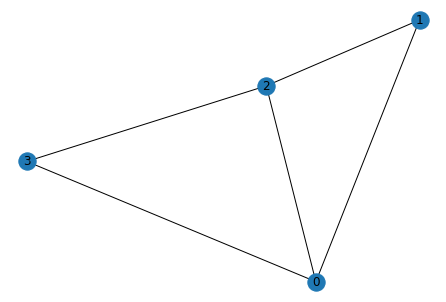

In [33]:
n_wires = 4
nodes = range(n_wires)
graph = [(0,1,0.5),(1,2,5),(2,0,1.5), (2,3,1.7), (0,3,0.5)] # input the edges here. 3rd element of each tuple is the weight. 
graphy = nx.Graph() 
graphy.add_nodes_from(nodes)
graphy.add_weighted_edges_from(graph) # change 1
nx.draw(graphy, with_labels=True)
plt.show() 

# unitary operator U_B with parameter beta
def U_B(beta):
    for wire in range(n_wires):
        qml.RX(2 * beta, wires=wire)


# unitary operator U_C with parameter gamma
def U_C(gamma):
    for edge in graph:
        wire1 = edge[0]
        wire2 = edge[1]
        weight = edge[2]
        qml.CNOT(wires=[wire1, wire2])
        qml.RZ(gamma*weight, wires=wire2)
        qml.CNOT(wires=[wire1, wire2])

In [17]:
def comp_basis_measurement(wires):
    n_wires = len(wires)
    hold = qml.Hermitian(np.diag(range(2 ** n_wires)), wires=wires)
    return hold

In [18]:
dev = qml.device("default.qubit", wires=n_wires, analytic=True, shots=1)

In [19]:
pauli_z = [[1, 0], [0, -1]]
pauli_z_2 = np.kron(pauli_z, pauli_z)


@qml.qnode(dev)
def circuit(gammas, betas, edge=None, n_layers=1):
    # apply Hadamards to get the n qubit |+> state
    for wire in range(n_wires):
        qml.Hadamard(wires=wire)
    # p instances of unitary operators
    for i in range(n_layers):
        # print(f'gammas: {gammas}')
        U_C(gammas[i])
        U_B(betas[i])
    hold = qml.sample(comp_basis_measurement(range(n_wires)))
    return hold        

In [20]:
def decimal_to_binary(decimal): # future: abstract this to take in lenght.
    binary_num = []
    
    def convert(decimal):
        if decimal >= 1:
            convert(decimal // 2)
            binary_num.append(decimal % 2)
    
    convert(decimal)
            
    for i in range(n_wires + 1):
        if len(binary_num) < i:
            binary_num.insert(0, 0) # At beginning append 0
    
    return binary_num # outputs array of bin.

In [21]:
n_layers = 4

def get_counts(params):
    # print("\np={:d}".format(n_layers))
    
    gammas = [params[0], params[2], params[4], params[6]]
    betas = [params[1], params[3], params[5], params[7]]
    
    # sample measured bitstrings 100 times
    bit_strings = []
    num_reps = 100
    for i in range(0, num_reps):
        # print("can come here")
        # print(f'params: {params}')
        # hold = int(circuit(params[0], params[1], edge=None, n_layers=n_layers)) change bc new optimizer
        hold = int(circuit(gammas, betas, edge=None, n_layers=n_layers))
        # print(f'What we are appending: {hold}')
        bit_strings.append(hold) # This appends the integer from 0-15 (if 4 nodes) so it outputs the computational basis measurement in decimal. 
        # print(f"int circuit right before int-ing: {circuit(params[0], params[1], edge=None, n_layers=n_layers)}")
        # print(f"int circuit: {int(circuit(params[0], params[1], edge=None, n_layers=n_layers))}")

    # print optimal parameters and most frequently sampled bitstring
    counts = np.bincount(np.array(bit_strings))
    most_freq_bit_string = np.argmax(counts)

    return counts, bit_strings

In [22]:
# run decimal to binary to each eleemtn of bit_strings and then apply the cirq func

def get_binary_bit_strings(bit_strings):
    bit_strings_binary = []
    for bit in bit_strings:
        bit_strings_binary.append(decimal_to_binary(bit))
    return bit_strings_binary

In [39]:
# Cost function

def cost_function(params):
    # print(f'params at beginning of cost func: {params}')
    bit_strings = get_counts(params)[1]
    binary_bit_strings = get_binary_bit_strings(bit_strings)
    total_cost = 0
    for i in range(0, len(binary_bit_strings)):
        for edge in graph:
            start_node = edge[0]
            end_node = edge[1]
            weight = edge[2]
            unweighted_cost = 0.5*( ( (1 - 2*binary_bit_strings[i][start_node]) * (1 - 2*binary_bit_strings[i][end_node]) ) - 1)
            weighted_cost = unweighted_cost * weight
            weighted_cost = -1 * (weight * binary_bit_strings[i][start_node] * (1 - binary_bit_strings[i][end_node]) + weight * binary_bit_strings[i][end_node] * (1 - binary_bit_strings[i][start_node])) 
            total_cost += weighted_cost
        
    # total_cost = float(total_cost)/rep

    print("Cost: "+str(total_cost))

    return total_cost

In [40]:
# initialize the parameters near zero
init_params = 0.01 * np.random.rand(2, n_layers) # change 4 -> maxcut unrelated, just so i can have 3 layers.
params = init_params
# cost function here works. but not in the optimizer.
# print(f'init params: {params}')

from scipy.optimize import minimize
out = minimize(cost_function, x0=params, method="COBYLA", options={'maxiter':100}) # this line changes params from a 2x4 array into a 1x8 array. :/
print(f'Out: {out}')

Cost: -498.79999999999956
Cost: -479.09999999999957
Cost: -435.1999999999996
Cost: -447.39999999999964
Cost: -466.99999999999955
Cost: -441.5999999999996
Cost: -498.1999999999996
Cost: -519.7999999999996
Cost: -389.99999999999955
Cost: -469.99999999999955
Cost: -419.0999999999995
Cost: -407.4999999999997
Cost: -480.8999999999996
Cost: -420.5999999999996
Cost: -430.99999999999966
Cost: -526.5999999999997
Cost: -113.60000000000002
Cost: -444.99999999999966
Cost: -689.6000000000006
Cost: -420.4999999999995
Cost: -548.9999999999995
Cost: -348.89999999999964
Cost: -595.6999999999999
Cost: -709.3000000000004
Cost: -747.4000000000005
Cost: -600.3000000000001
Cost: -718.5000000000003
Cost: -692.9000000000005
Cost: -616.0000000000001
Cost: -685.0000000000005
Cost: -450.0999999999995
Cost: -650.5000000000005
Cost: -602.5
Cost: -701.0000000000007
Cost: -680.9000000000005
Cost: -705.5000000000006
Cost: -719.6000000000007
Cost: -732.2000000000007
Cost: -679.2000000000005
Cost: -723.7000000000007
Co

In [41]:
optimal_params = out['x'] # bruh this shit outputs in a 2x4 array
optimal_params_vector = []
for j in range(len(optimal_params[0])):
    optimal_params_vector.append(optimal_params[0][j])
    optimal_params_vector.append(optimal_params[1][j]) # optimal_params_vector is good
    
print(optimal_params_vector) # oh bruh this shit is an array not a tensor so it doesnt work wtf
final_bitstring = get_counts(optimal_params_vector)[1]
print(final_bitstring)

[-0.05074532020177523, -0.043802084304300506, 0.05914225125360394, 0.5276992648686096, 0.44007416717301284, -0.47742202213213214, 1.120867197920408, -0.2409086130601557]
[14, 13, 2, 1, 7, 2, 13, 12, 2, 2, 13, 12, 13, 2, 13, 2, 2, 13, 13, 2, 13, 13, 2, 13, 8, 13, 7, 5, 13, 2, 1, 13, 13, 2, 2, 13, 2, 3, 2, 12, 1, 12, 13, 7, 2, 2, 2, 5, 13, 0, 13, 13, 4, 2, 13, 13, 14, 3, 13, 2, 3, 5, 4, 12, 2, 13, 11, 13, 0, 12, 3, 8, 13, 2, 2, 13, 8, 2, 7, 5, 13, 0, 12, 12, 13, 13, 4, 2, 2, 2, 2, 13, 13, 3, 2, 2, 13, 13, 2, 12]


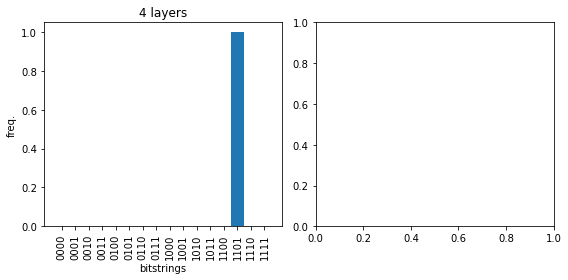

In [43]:
import matplotlib.pyplot as plt

xticks = range(0, 16)
xtick_labels = list(map(lambda x: format(x, "04b"), xticks))
bins = np.arange(0, 17) - 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("4 layers")
plt.xlabel("bitstrings")
plt.ylabel("freq.")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(final_bitstring[1], bins=bins)
plt.subplot(1, 2, 2)

plt.tight_layout()
plt.show()

In [ ]:
# Sort of success -  I got 1/2 of the answer 😅